In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

import cudf
import cupy as cp
from cuml.preprocessing import SimpleImputer 
from sklearn.model_selection import ParameterGrid 
from cuml.manifold import TSNE
from cuml.manifold import UMAP
from cuml.cluster import KMeans, DBSCAN, AgglomerativeClustering
from cuml.pipeline import Pipeline
from cuml.preprocessing import StandardScaler
from cuml.metrics.cluster import silhouette_score
from cuml.common import input_to_cuml_array

from cuml.metrics.cluster import adjusted_rand_score
from cuml.preprocessing import FunctionTransformer
from cuml.cluster.hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, make_scorer


/home/revel/.venv/lib/python3.12/site-packages/cupy/_environment.py:541: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


Проверить драйвер

```bash
nvidia-smi
```

Для запуска нужно установить для (Ubuntu/Debian)

```bash
sudo apt install cuda
wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64/cuda-keyring_1.1-1_all.deb
sudo apt install ./cuda-keyring_1.1-1_all.deb
sudo apt update
sudo apt install cuda-toolkit
```

In [2]:
dataset_url = 'https://www.kaggle.com/competitions/clustering-physical-activity-data'
od.download(dataset_url)

Skipping, found downloaded files in "./clustering-physical-activity-data" (use force=True to force download)


In [3]:
df = pd.read_csv('./clustering-physical-activity-data/Physical_Activity_Monitoring_unlabeled.csv', dtype='float32')
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534601 entries, 0 to 534600
Data columns (total 53 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   timestamp          534601 non-null  float32
 1   handTemperature    530560 non-null  float32
 2   handAcc16_1        530560 non-null  float32
 3   handAcc16_2        530560 non-null  float32
 4   handAcc16_3        530560 non-null  float32
 5   handAcc6_1         530560 non-null  float32
 6   handAcc6_2         530560 non-null  float32
 7   handAcc6_3         530560 non-null  float32
 8   handGyro1          530560 non-null  float32
 9   handGyro2          530560 non-null  float32
 10  handGyro3          530560 non-null  float32
 11  handMagne1         530560 non-null  float32
 12  handMagne2         530560 non-null  float32
 13  handMagne3         530560 non-null  float32
 14  handOrientation1   530560 non-null  float32
 15  handOrientation2   530560 non-null  float32
 16  ha

In [4]:
df.fillna(0)

df.head()

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,252.750000,34.8750,0.902847,7.45872,6.032490,1.006100,7.44575,6.303650,-0.021952,0.004114,...,-0.025606,0.030239,-14.544700,27.333599,-5.766200,0.206416,0.348212,0.763201,-0.503652,5.0
1,3652.449951,29.7500,-4.069330,3.76168,8.279720,-5.972500,3.22273,6.908970,0.116054,-0.375968,...,-0.670163,1.786200,-32.825699,-15.771900,-1.313950,0.578332,-0.566734,0.405888,-0.423791,2.0
2,504.760010,34.3750,-2.007540,-9.60180,0.773674,-1.803500,-9.58937,1.073680,0.020131,0.042189,...,-0.009741,-0.006579,-18.817101,16.308901,25.292801,0.139776,0.676586,0.393796,0.606316,8.0
3,2801.610107,31.9375,-13.262200,5.85443,0.899334,-13.611500,5.91511,0.840377,1.715630,-0.050492,...,-0.163470,-3.495570,-26.741800,34.356602,21.327400,0.416303,0.783387,0.306464,0.345075,2.0
4,441.010010,33.5000,-0.013940,8.66540,4.398210,0.144153,8.56816,4.822200,-0.006938,-0.007383,...,-0.028172,-0.003737,-17.779800,-3.998100,10.995000,0.171133,-0.748343,0.252988,-0.588807,6.0


In [5]:
def preprocess_data(data):
    if 'timestamp' in data.columns:
        data = data.drop('timestamp', axis=1)
    if 'subject_id' in data.columns:
        data = data.drop('subject_id', axis=1)
    
    return data

df = preprocess_data(df)

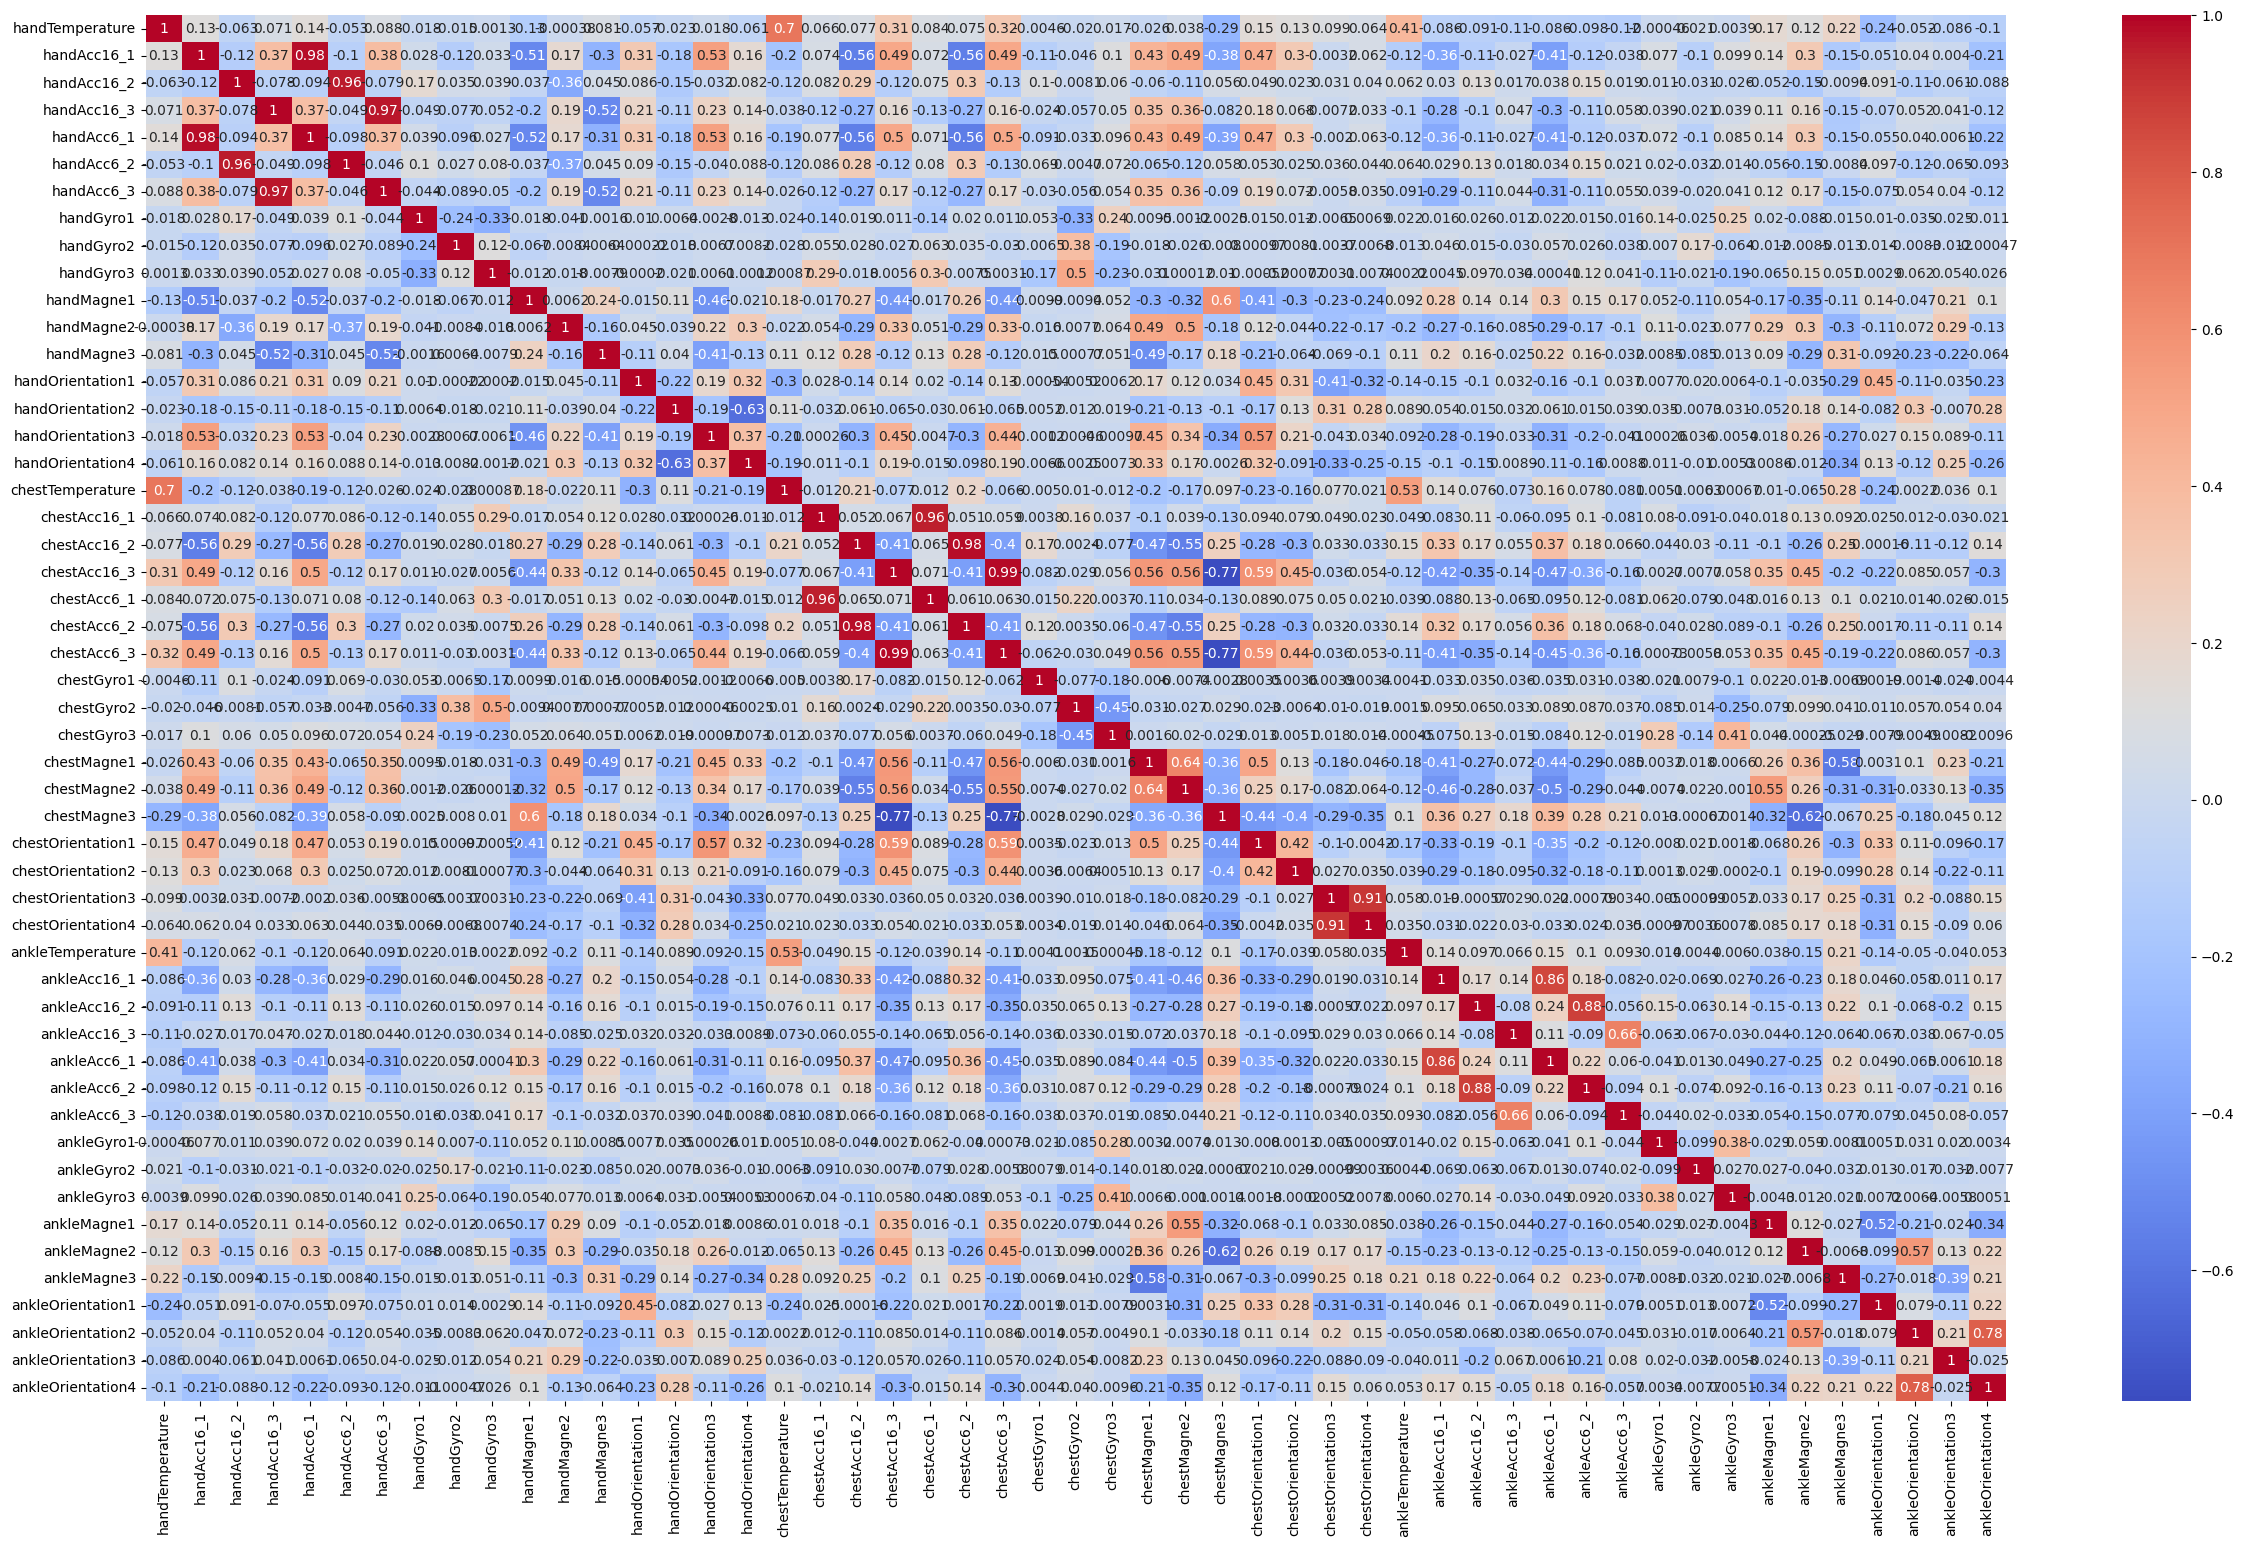

In [6]:
# Тепловая карта корреляций
plt.figure(figsize = (30, 18))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
plt.show()


/tmp/ipykernel_52216/3476872050.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne.values[:, 0], X_tsne.values[:, 1], cmap='Spectral', edgecolors='k')


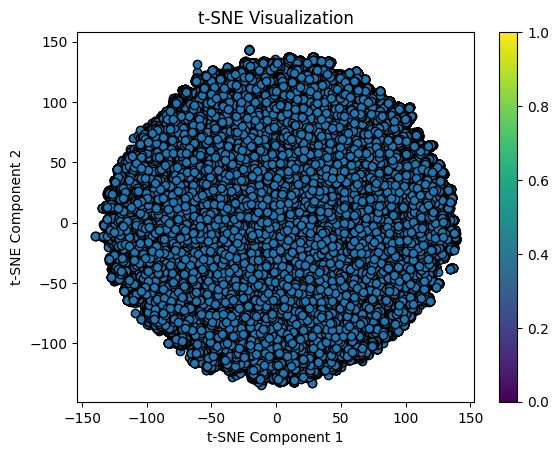

In [18]:
# Применяем t-SNE для уменьшения размерности до 2D
tsne = TSNE(   
    n_components=2,
    perplexity=10,       # Попробуйте значения 5-50 (меньше для четких групп)
    learning_rate=150,  # 10-1000 (меньше для плотных кластеров)
    n_iter=2500,       # Увеличьте до 2000-5000 для лучшей сходимости
    random_state=42,
    early_exaggeration=24,  # 12-32 (усиливает разделение групп)
    metric='cosine'  # Или 'euclidean' 
)
df_cleaned = df.dropna()
X_tsne = tsne.fit_transform(df_cleaned)

plt.scatter(X_tsne.values[:, 0], X_tsne.values[:, 1], cmap='Spectral', edgecolors='k')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.colorbar()
plt.show()

После тестирования t-SNE визуализации я столкнулся с тем, что кластеры выглядят размытыми и недостаточно четко разделенными. Визуально сложно различить отдельные группы точек

[2025-04-21 11:05:30.840] [CUML] [info] build_algo set to brute_force_knn because random_state is given


/tmp/ipykernel_52216/1599287297.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne.values[:, 0], X_tsne.values[:, 1], cmap='Spectral', edgecolors='k')


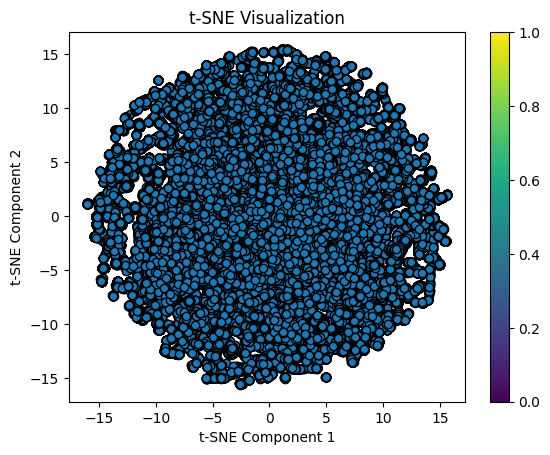

In [19]:
tsne = UMAP(n_components=2, n_neighbors=20, min_dist=0.1, metric='cosine', random_state=42)
df_cleaned = df.dropna()
X_tsne = tsne.fit_transform(df_cleaned)

plt.scatter(X_tsne.values[:, 0], X_tsne.values[:, 1], cmap='Spectral', edgecolors='k')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.colorbar()
plt.show()

Как будто UMAP лучше работает но так же сложно выделить группы

In [9]:
class CorrelationRemoverGPU(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.high_corr_features = None
        self.feature_names_ = None
    
    def fit(self, X, y=None):
        if not isinstance(X, cudf.DataFrame):
            X = cudf.DataFrame(X)
        
        corr_matrix = X.corr().values
        upper = cp.triu(cp.ones(corr_matrix.shape), k=1).astype(bool)
        rows, cols = cp.where(upper)
        
        to_drop = set()
        for i, j in zip(rows.get(), cols.get()):
            if abs(corr_matrix[i, j]) > self.threshold:
                to_drop.add(j)
        
        self.high_corr_features = sorted(to_drop)
        return self
    
    def transform(self, X):
        if self.high_corr_features is None:
            return X.values.get() if isinstance(X, cudf.DataFrame) else X
            
        if not isinstance(X, cudf.DataFrame):
            X = cudf.DataFrame(X)
            
        result = X.drop(X.columns[self.high_corr_features], axis=1)
        self.feature_names_ = result.columns.to_list()
        return result.values.get()

In [10]:
# Пайплайн для кластеризации
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()), 
    ('corr_remover', CorrelationRemoverGPU(threshold=0.9)),
    ('cluster', 'passthrough')
])

# Параметры для поиска
param_grid = [
    {
        'cluster': [KMeans(random_state=42)],
        'cluster__n_clusters': [3],
        'cluster__init': ['scalable-k-means++', 'random'],
        'cluster__max_iter': [100],
        'cluster__tol': [1e-4],
        'cluster__oversampling_factor': [3.0], 
        'cluster__max_samples_per_batch': [32768],
        'cluster__n_init': ['auto'],
    },
    {
        'cluster': [AgglomerativeClustering()],
        'cluster__n_clusters': [3],
        'cluster__linkage': ['ward']
    },
    # {
    #     'cluster': [DBSCAN()],
    #     'cluster__eps': [0.3, 0.5, 1.0],
    #     'cluster__min_samples': [3, 5, 10]
    # },
    # {
    #     'cluster': [HDBSCAN()],
    #     'cluster__min_cluster_size': [3, 5, 10]
    # },
    # {
    #     'cluster': [DBSCAN()],
    #     'cluster__eps': [0.3, 0.5, 1.0],
    #     'cluster__min_samples': [3, 5, 10]
    # },
    # {
    #     'cluster': [AgglomerativeClustering()],
    #     'cluster__n_clusters': [3, 5, 10],
    #     'cluster__linkage': ['ward', 'complete', 'average']
    # }
]

После всех экспериментов лучше всего показали себя KMeans и AgglomerativeClustering с заданными параметрами. KMeans продемонстрировал оптимальное сочетание качества и скорости, особенно при использовании инициализации scalable-k-means++. AgglomerativeClustering с методом ward также обеспечил четкое разделение на кластеры.

Другие алгоритмы, такие как DBSCAN и HDBSCAN, тестировались на уменьшенной выборке данных, но показали более низкую эффективность. Поскольку выбранные методы дали удовлетворительные результаты, было принято решение остановиться на них.

In [11]:
# Функция для метода локтя
def elbow_method(X, max_clusters=10):
    distortions = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method For Optimal k')
    plt.grid()
    plt.show()

In [ ]:
# Boxplot для всех числовых столбцов
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Распределение признаков с выбросами")
plt.show()

In [14]:
def clustering_scorer(estimator, X):
    try:
        labels = estimator.fit_predict(X)
        
        # Если все точки в одном кластере → возвращаем -1
        if len(np.unique(labels)) < 2:
            return -1
        
        # Если есть NaN → заменяем их на 0 (или пропускаем)
        if np.isnan(X).any():
            X = np.nan_to_num(X)  # Заменяем NaN на 0
        
        return silhouette_score(X, labels)  # или calinski_harabasz_score(X, labels)
    
    except:  # Если вообще всё сломалось
        return -1


# Конвертируем данные в numpy (если используем GPU, убедитесь в совместимости)
X = df.values if hasattr(df, 'values') else df.to_numpy()

# Создаем кастомный scorer для silhouette_score
silhouette_scorer = make_scorer(silhouette_score)

search = GridSearchCV(pipeline, param_grid, cv=2, scoring=clustering_scorer, verbose=3)
search.fit(X)  # X должен быть numpy array или cuDF DataFrame


Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END cluster=KMeans(), cluster__init=scalable-k-means++, cluster__max_iter=100, cluster__max_samples_per_batch=32768, cluster__n_clusters=3, cluster__n_init=auto, cluster__oversampling_factor=3.0, cluster__tol=0.0001;, score=0.310 total time=13.3min
[CV 2/2] END cluster=KMeans(), cluster__init=scalable-k-means++, cluster__max_iter=100, cluster__max_samples_per_batch=32768, cluster__n_clusters=3, cluster__n_init=auto, cluster__oversampling_factor=3.0, cluster__tol=0.0001;, score=0.311 total time=15.0min
[CV 1/2] END cluster=KMeans(), cluster__init=random, cluster__max_iter=100, cluster__max_samples_per_batch=32768, cluster__n_clusters=3, cluster__n_init=auto, cluster__oversampling_factor=3.0, cluster__tol=0.0001;, score=0.182 total time=15.0min
[CV 2/2] END cluster=KMeans(), cluster__init=random, cluster__max_iter=100, cluster__max_samples_per_batch=32768, cluster__n_clusters=3, cluster__n_init=auto, cluster__oversamplin

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('corr_remover',
                                        CorrelationRemoverGPU()),
                                       ('cluster', 'passthrough')]),
             param_grid=[{'cluster': [KMeans()],
                          'cluster__init': ['scalable-k-means++', 'random'],
                          'cluster__max_iter': [100],
                          'cluster__max_samples_per_batch': [32768],
                          'cluster__n_clusters': [3],
                          'cluster__n_init': ['auto'],
                          'cluster__oversampling_factor': [3.0],
                          'cluster__tol': [0.0001]},
                         {'cluster': [AgglomerativeClustering()],
                          'cluster__linkage': ['ward'],
                          'cluster__n_clusters': [3]}],
             scoring=<function clustering_scorer at 0x7fe09e93d4e0>, verbose=3)

In [15]:
# Вывод всех доступных метрик
for i in range(len(search.cv_results_['params'])):
    print(f"Вариант {i+1}:")
    print(f"Параметры: {search.cv_results_['params'][i]}")
    print(f"Средний score: {search.cv_results_['mean_test_score'][i]:.4f}")
    print(f"Стандартное отклонение: {search.cv_results_['std_test_score'][i]:.4f}")
    print(f"Ранг: {search.cv_results_['rank_test_score'][i]}")
    print("-" * 50)

Вариант 1:
Параметры: {'cluster': KMeans(), 'cluster__init': 'scalable-k-means++', 'cluster__max_iter': 100, 'cluster__max_samples_per_batch': 32768, 'cluster__n_clusters': 3, 'cluster__n_init': 'auto', 'cluster__oversampling_factor': 3.0, 'cluster__tol': 0.0001}
Средний score: 0.3102
Стандартное отклонение: 0.0006
Ранг: 2
--------------------------------------------------
Вариант 2:
Параметры: {'cluster': KMeans(), 'cluster__init': 'random', 'cluster__max_iter': 100, 'cluster__max_samples_per_batch': 32768, 'cluster__n_clusters': 3, 'cluster__n_init': 'auto', 'cluster__oversampling_factor': 3.0, 'cluster__tol': 0.0001}
Средний score: 0.1564
Стандартное отклонение: 0.0259
Ранг: 3
--------------------------------------------------
Вариант 3:
Параметры: {'cluster': AgglomerativeClustering(), 'cluster__linkage': 'ward', 'cluster__n_clusters': 3}
Средний score: 0.5832
Стандартное отклонение: 0.0064
Ранг: 1
--------------------------------------------------


In [16]:
# Получение лучшей модели и меток кластеров
best_model = search.best_estimator_
labels = best_model.named_steps['cluster'].labels_

result_df = pd.DataFrame({
    'Index': range(0, len(labels)),
    'original_cluster': labels
})

# Преобразуем метки в последовательные числа 
unique_clusters = sorted(np.unique(labels))
cluster_mapping = {old: new for new, old in enumerate(unique_clusters, 1)} 
result_df['activityID'] = result_df['original_cluster'].map(cluster_mapping)

# Формируем финальный DataFrame для выгрузки
submission_df = result_df[['Index', 'activityID']]

submission_df.to_csv('submission.csv', index=False)
print("Пример преобразования:")
print(submission_df.head(10))

Пример преобразования:
   Index  activityID
0      0           1
1      1           1
2      2           1
3      3           1
4      4           1
5      5           1
6      6           1
7      7           1
8      8           1
9      9           1


Лучшие параметры: {'cluster': AgglomerativeClustering(), 'cluster__linkage': 'ward', 'cluster__n_clusters': 3}
Silhouette Score: 0.5832060873508453
Размер X_clean: (527389, 51), размер labels_clean: (527389,)
[2025-04-21 10:13:35.348] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


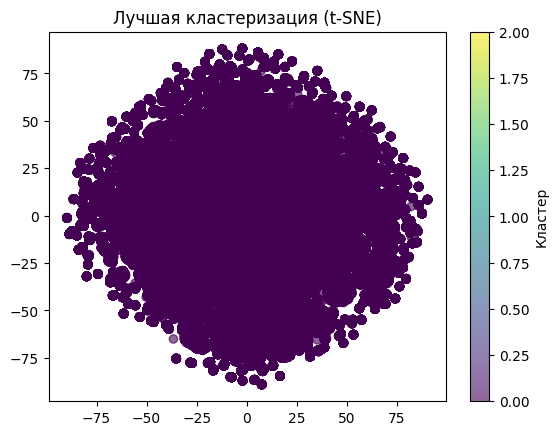

In [17]:
print("Лучшие параметры:", search.best_params_)
print("Silhouette Score:", search.best_score_)

# Удаляем строки с NaN и соответствующие метки
nan_mask = ~np.isnan(X).any(axis=1)
X_clean = X[nan_mask]
labels_clean = search.best_estimator_.named_steps['cluster'].labels_[nan_mask]

# Проверка размерностей
print(f"Размер X_clean: {X_clean.shape}, размер labels_clean: {labels_clean.shape}")

# Уменьшаем размерность только если данные без NaN
if len(X_clean) > 0:
    X_embedded = TSNE(n_components=2).fit_transform(X_clean)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 
                c=labels_clean, 
                cmap='viridis', 
                alpha=0.6)
    plt.colorbar(label="Кластер")
    plt.title("Лучшая кластеризация (t-SNE)")
    plt.show()
else:
    print("Внимание: После удаления NaN не осталось данных для визуализации!")

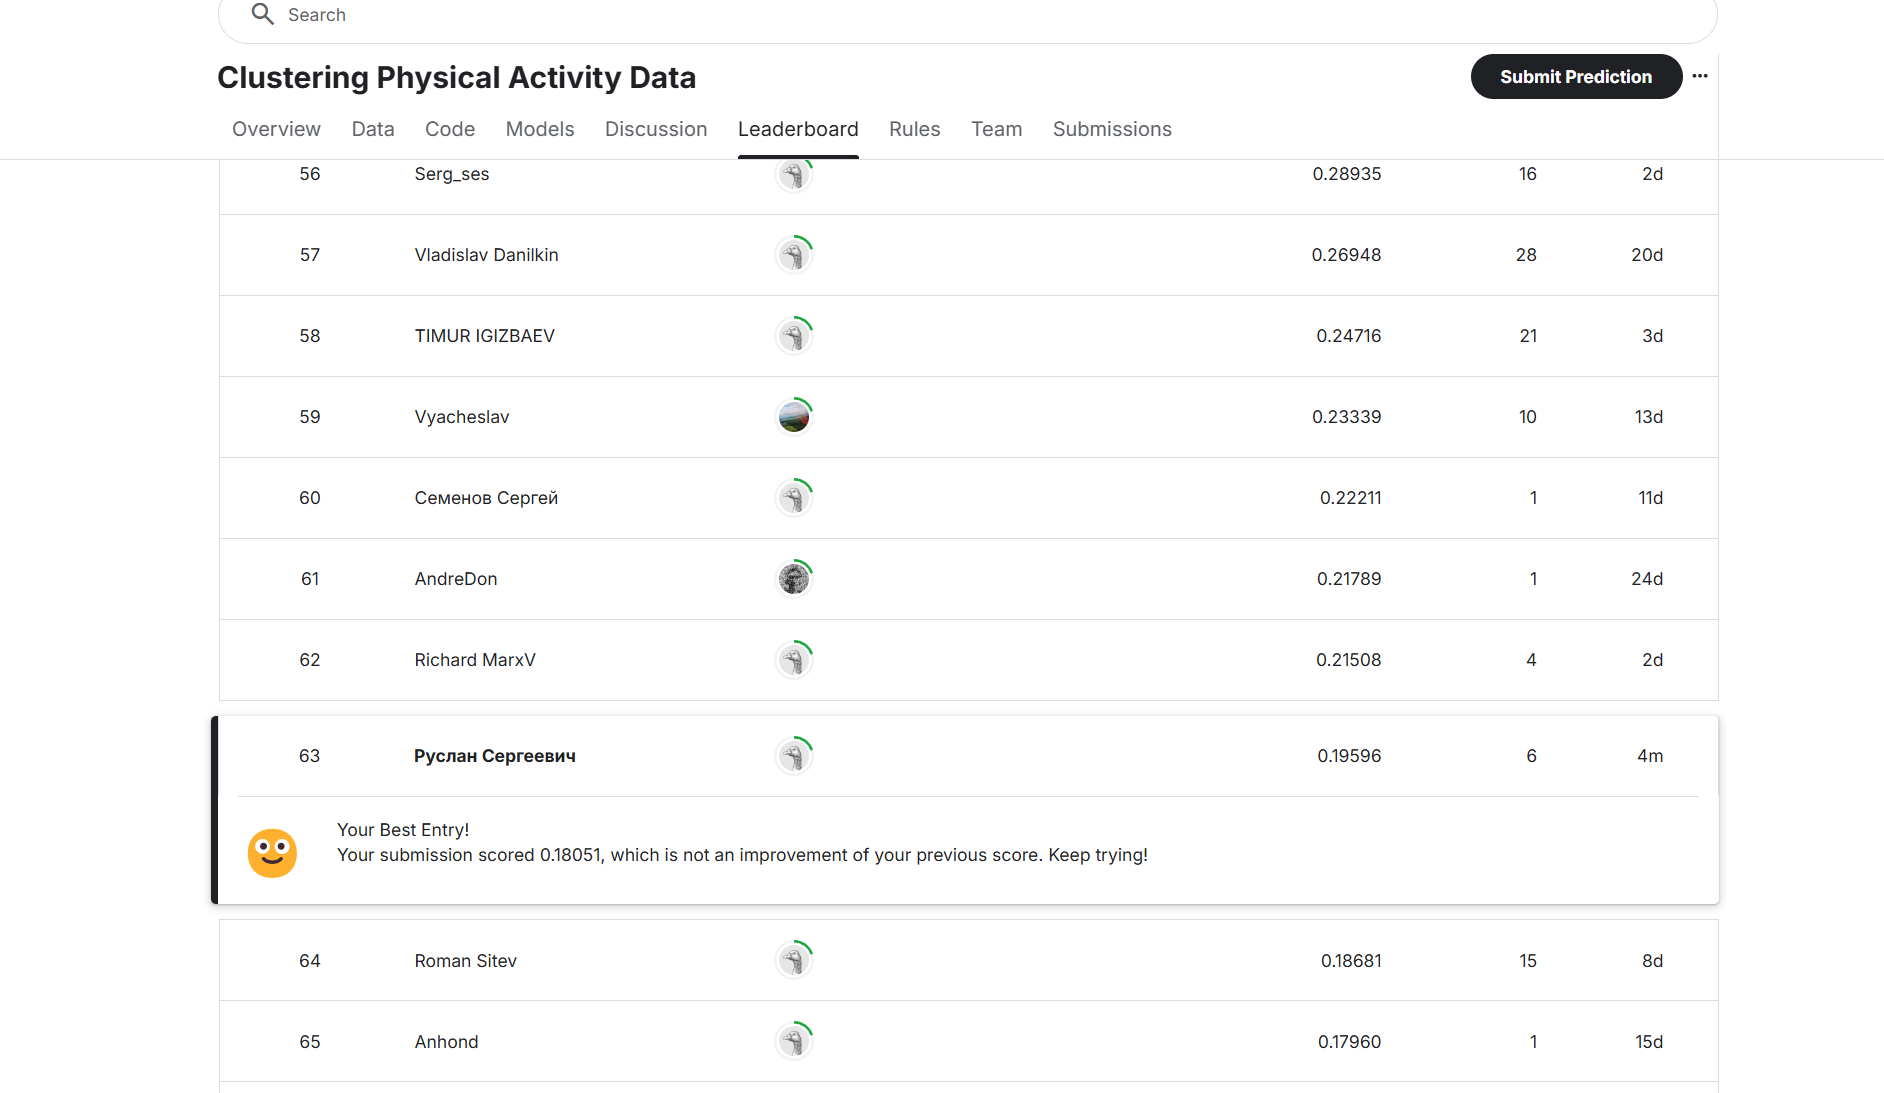